In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from src.simulator.ssa import SSASimulator
import numpy as np
from src.estimation.fullobsnn import CombinedReactionsNN
from src.estimation.fullobsnn import DataPreparatorFullObs
from src.models.utils import getReactionsForObservations
from src.estimation.utils import createPropensityPlot
from src.estimation.mle import MLEstimator

2023-09-06 14:01:19.401648: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 14:01:19.493809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 14:01:19.494867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 14:01:21.072267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [3]:
from src.models.example_networks import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
x0 = model_bd.getDefaultInitialState()

We set up the NN model

In [4]:
data_preparator = DataPreparatorFullObs()
num_trajs = 100
for num_traj in range(num_trajs):
    y, t = simulator_bd.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)
    
num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = CombinedReactionsNN(num_inputs = num_states, num_outputs=num_unique_stoch, num_layers=2, num_neurons=8, learning_rate=0.001)
train_dataset = data_preparator.getTraindDataset()

We train the model on the training data

In [5]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
74/74 [==============================] - 2s 4ms/step - loss: 67113.5391
Epoch 2/200
74/74 [==============================] - 0s 4ms/step - loss: 66621.3203
Epoch 3/200
74/74 [==============================] - 0s 3ms/step - loss: 66207.1328
Epoch 4/200
74/74 [==============================] - 0s 4ms/step - loss: 65974.4609
Epoch 5/200
74/74 [==============================] - 0s 3ms/step - loss: 65884.8359
Epoch 6/200
74/74 [==============================] - 0s 4ms/step - loss: 65848.7031
Epoch 7/200
74/74 [==============================] - 0s 4ms/step - loss: 65825.8594
Epoch 8/200
74/74 [==============================] - 0s 4ms/step - loss: 65807.1953
Epoch 9/200
74/74 [==============================] - 0s 4ms/step - loss: 65792.5938
Epoch 10/200
74/74 [==============================] - 0s 3ms/step - loss: 65781.0703
Epoch 11/200
74/74 [==============================] - 0s 4ms/step - loss: 65767.1641
Epoch 12/200
74/74 [==============================] - 0s 3ms/step - loss: 

We plot the estimation results

6/6 [==============================] - 0s 2ms/step


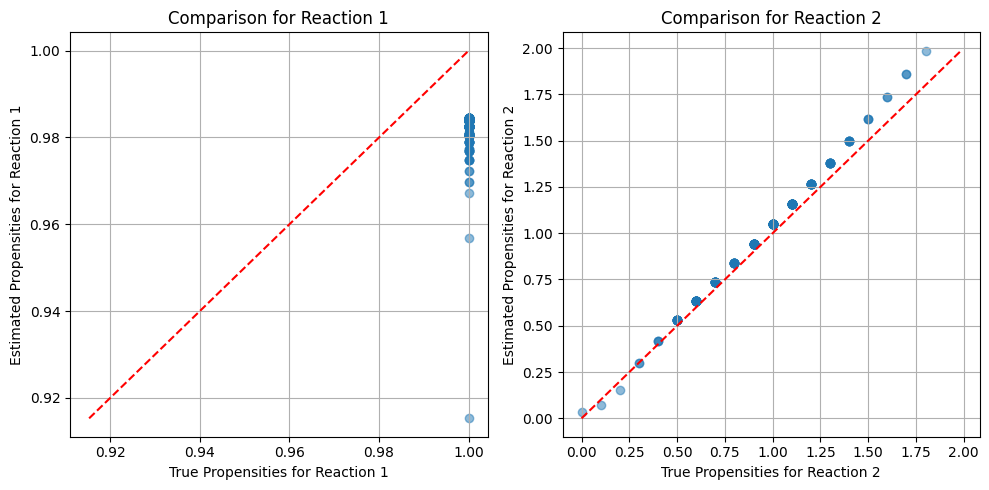

In [6]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)
plt.savefig("bd_comparison.svg")

Lets compare it with the MLE 

/tmp/ipykernel_156478/1584653936.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


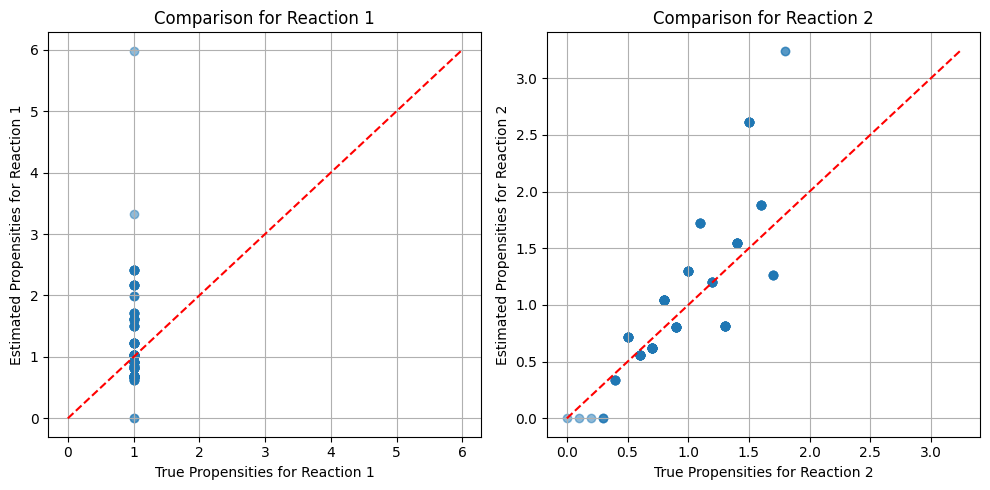

In [7]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()
plt.savefig("bd_comparison_MLE.svg")

# NN for Lotka-Voltera Model

In [3]:
from src.models.paper_examples import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
x0 = model_lv.getDefaultInitialState()

In [4]:

data_preparator = DataPreparatorFullObs()

num_trajs = 5
for num_traj in range(num_trajs):
    y, t = simulator_lv.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
custom_model = CombinedReactionsNN(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=6, num_neurons=1024)
train_dataset = data_preparator.getTraindDataset()

In [5]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
78/78 [==============================] - 14s 143ms/step - loss: 415552640.0000
Epoch 2/200
78/78 [==============================] - 11s 146ms/step - loss: 284201024.0000
Epoch 3/200
78/78 [==============================] - 11s 142ms/step - loss: 194921824.0000
Epoch 4/200
78/78 [==============================] - 12s 147ms/step - loss: 135796176.0000
Epoch 5/200
78/78 [==============================] - 12s 158ms/step - loss: 95816456.0000
Epoch 6/200
78/78 [==============================] - 11s 139ms/step - loss: 68456688.0000
Epoch 7/200
78/78 [==============================] - 11s 137ms/step - loss: 49098396.0000
Epoch 8/200
78/78 [==============================] - 12s 151ms/step - loss: 35278152.0000
Epoch 9/200
78/78 [==============================] - 12s 149ms/step - loss: 24830208.0000
Epoch 10/200
78/78 [==============================] - 12s 158ms/step - loss: 16529902.0000
Epoch 11/200
78/78 [==============================] - 12s 151ms/step - loss: 10130103.0000
Epoc

128/128 [==============================] - 1s 9ms/step


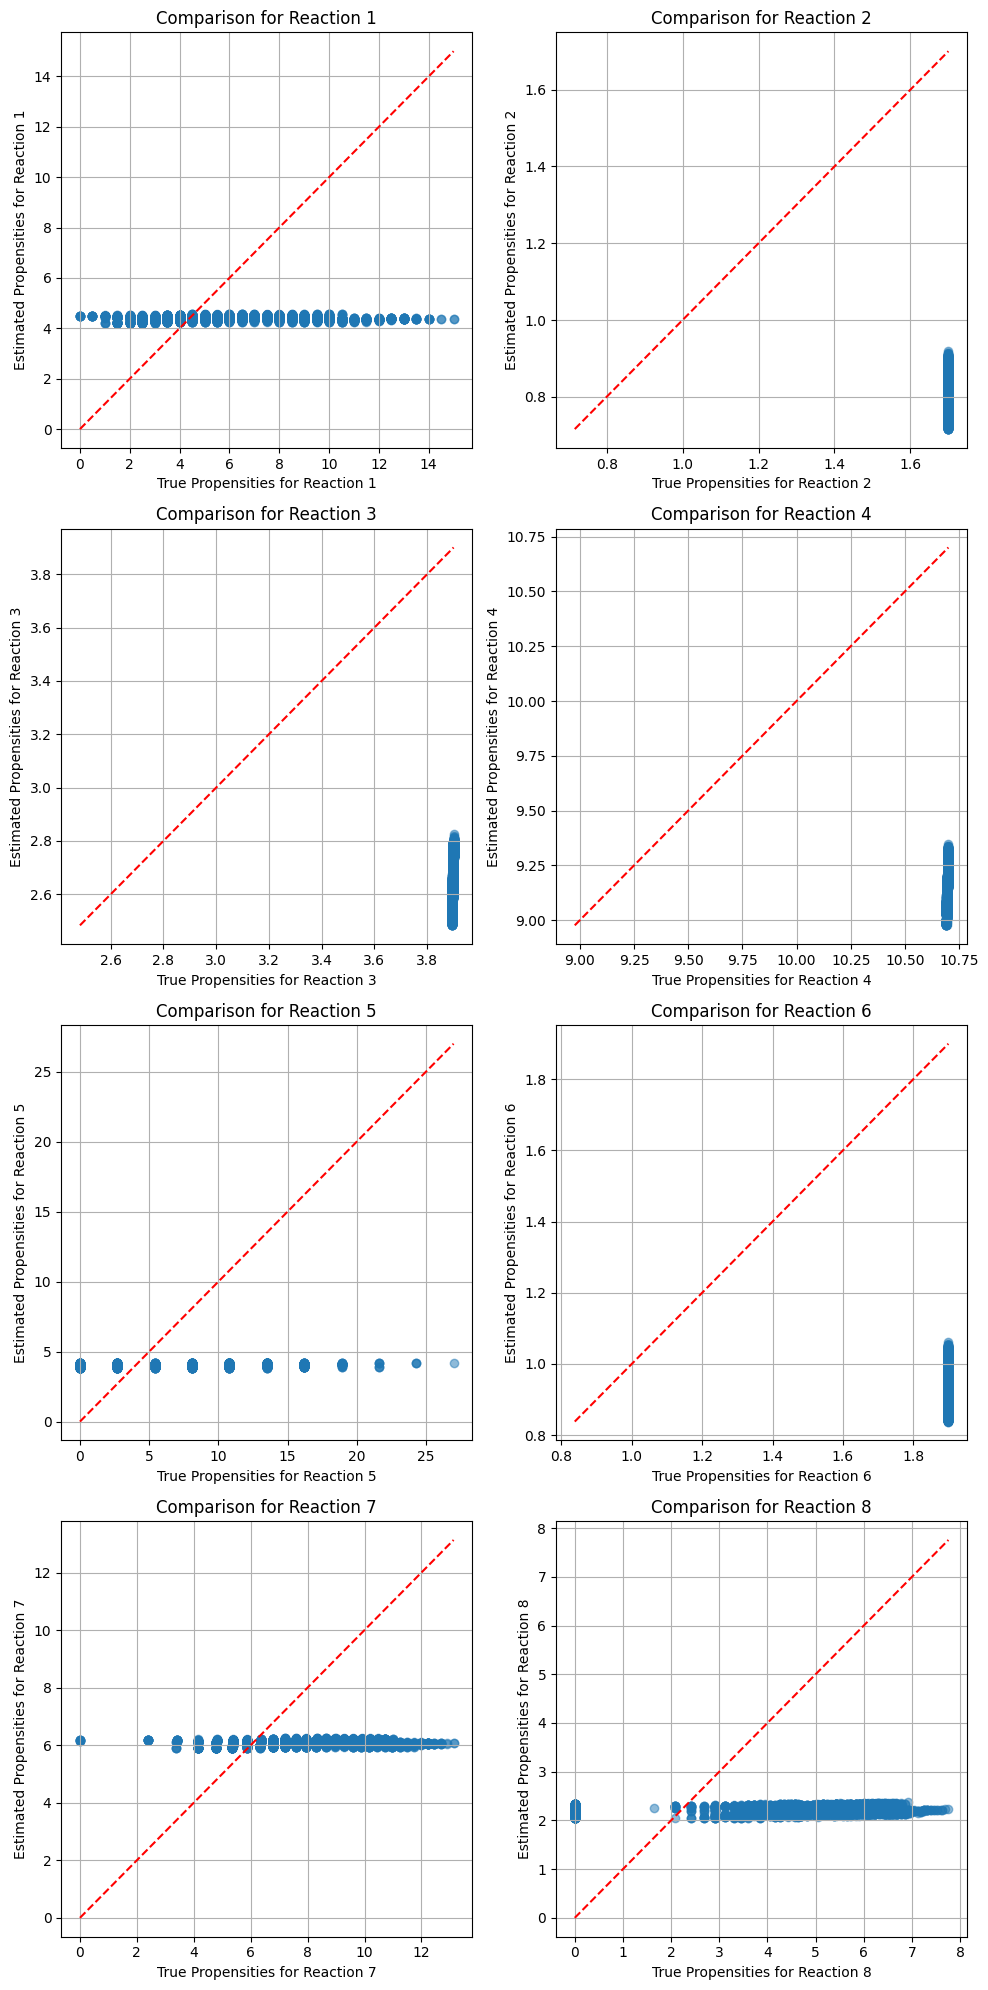

In [6]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [7]:
from src.models.paper_examples import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
x0 = model_crn.getDefaultInitialState()

In [8]:
data_preparator = DataPreparatorFullObs(batch_size=512)

num_trajs = 1
for num_traj in range(num_trajs):
    y, t = simulator_crn.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
custom_model = CombinedReactionsNN(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=6, num_neurons=1024)
train_dataset = data_preparator.getTraindDataset()

In [9]:
custom_model.fit(train_dataset, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 4392.4673
Epoch 2/1000
1/1 [==============================] - 0s 73ms/step - loss: 3590.3337
Epoch 3/1000
1/1 [==============================] - 0s 74ms/step - loss: 2891.9792
Epoch 4/1000
1/1 [==============================] - 0s 60ms/step - loss: 2516.6506
Epoch 5/1000
1/1 [==============================] - 0s 63ms/step - loss: 2849.1602
Epoch 6/1000
1/1 [==============================] - 0s 55ms/step - loss: 2932.7495
Epoch 7/1000
1/1 [==============================] - 0s 76ms/step - loss: 2634.7505
Epoch 8/1000
1/1 [==============================] - 0s 70ms/step - loss: 2416.7766
Epoch 9/1000
1/1 [==============================] - 0s 84ms/step - loss: 2395.9963
Epoch 10/1000
1/1 [==============================] - 0s 72ms/step - loss: 2475.5657
Epoch 11/1000
1/1 [==============================] - 0s 65ms/step - loss: 2557.8230
Epoch 12/1000
1/1 [==============================] - 0s 61ms/step - loss: 2598.0796
Epo

1/1 [==============================] - 0s 178ms/step


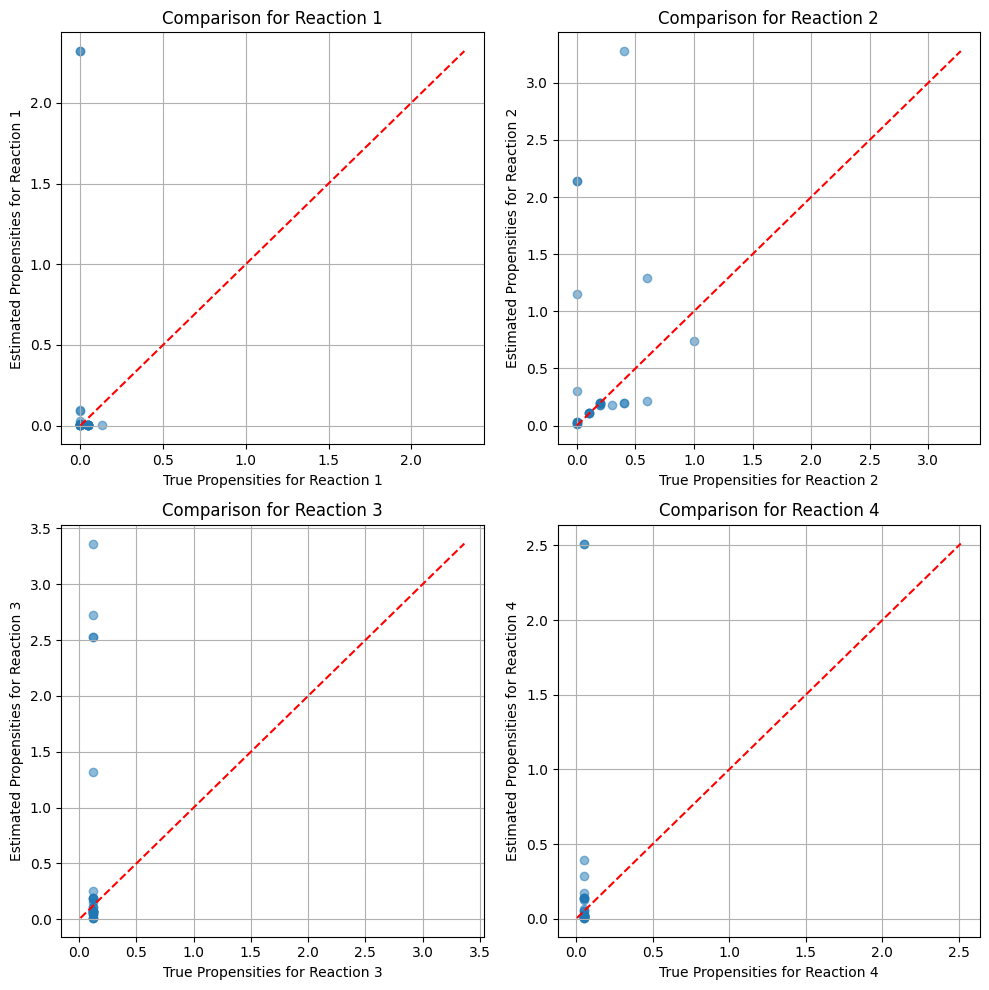

In [10]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with MLE

/tmp/ipykernel_143788/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


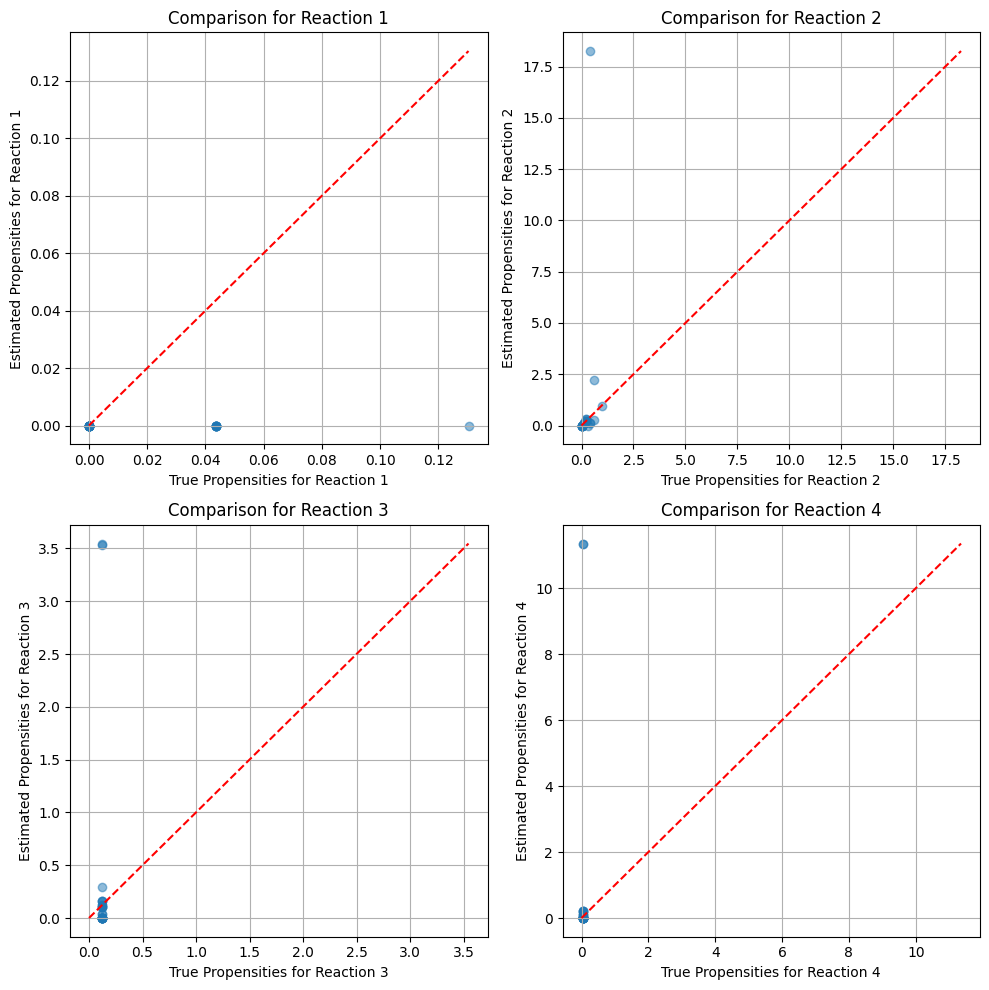

In [11]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# Lac-Gfp Model


In [8]:
from src.models.example_networks import LacGfp
model_lac = LacGfp()
simulator_lac = SSASimulator(model_lac)

parameters = model_lac.getDefaultParameter()
x0 = model_lac.getDefaultInitialState()
y, t = simulator_lac.run_ssa(x0, 10, parameters)
num_states = y.shape[1]

In [10]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = CombinedReactionsNN(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=4)
data_preparator = DataPreparatorFullObs(batch_size=1024)
data_preparator.addTrajectory(y, t, reaction_indices)

num_trajs = 50
for num_traj in range(num_trajs -1):
    y, t = simulator_lac.run_ssa(x0, 10, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)
    
train_dataset = data_preparator.getTraindDataset()

In [11]:
custom_model.fit(train_dataset, epochs=20)

Epoch 1/20
237/237 [==============================] - 56s 228ms/step - loss: -4712.2842
Epoch 2/20
237/237 [==============================] - 60s 252ms/step - loss: -5044.7710
Epoch 3/20
237/237 [==============================] - 60s 255ms/step - loss: -5098.7114
Epoch 4/20
237/237 [==============================] - 62s 261ms/step - loss: -5147.8330
Epoch 5/20
237/237 [==============================] - 83s 350ms/step - loss: -5088.8560
Epoch 6/20
237/237 [==============================] - 56s 237ms/step - loss: -5254.4585
Epoch 7/20
237/237 [==============================] - 51s 215ms/step - loss: -5278.5527
Epoch 8/20
237/237 [==============================] - 56s 234ms/step - loss: -5303.3203
Epoch 9/20
237/237 [==============================] - 54s 226ms/step - loss: -5311.7705
Epoch 10/20
237/237 [==============================] - 65s 275ms/step - loss: -5318.8936
Epoch 11/20
237/237 [==============================] - 51s 217ms/step - loss: -5316.6255
Epoch 12/20
237/237 [=========

126/126 [==============================] - 0s 1ms/step


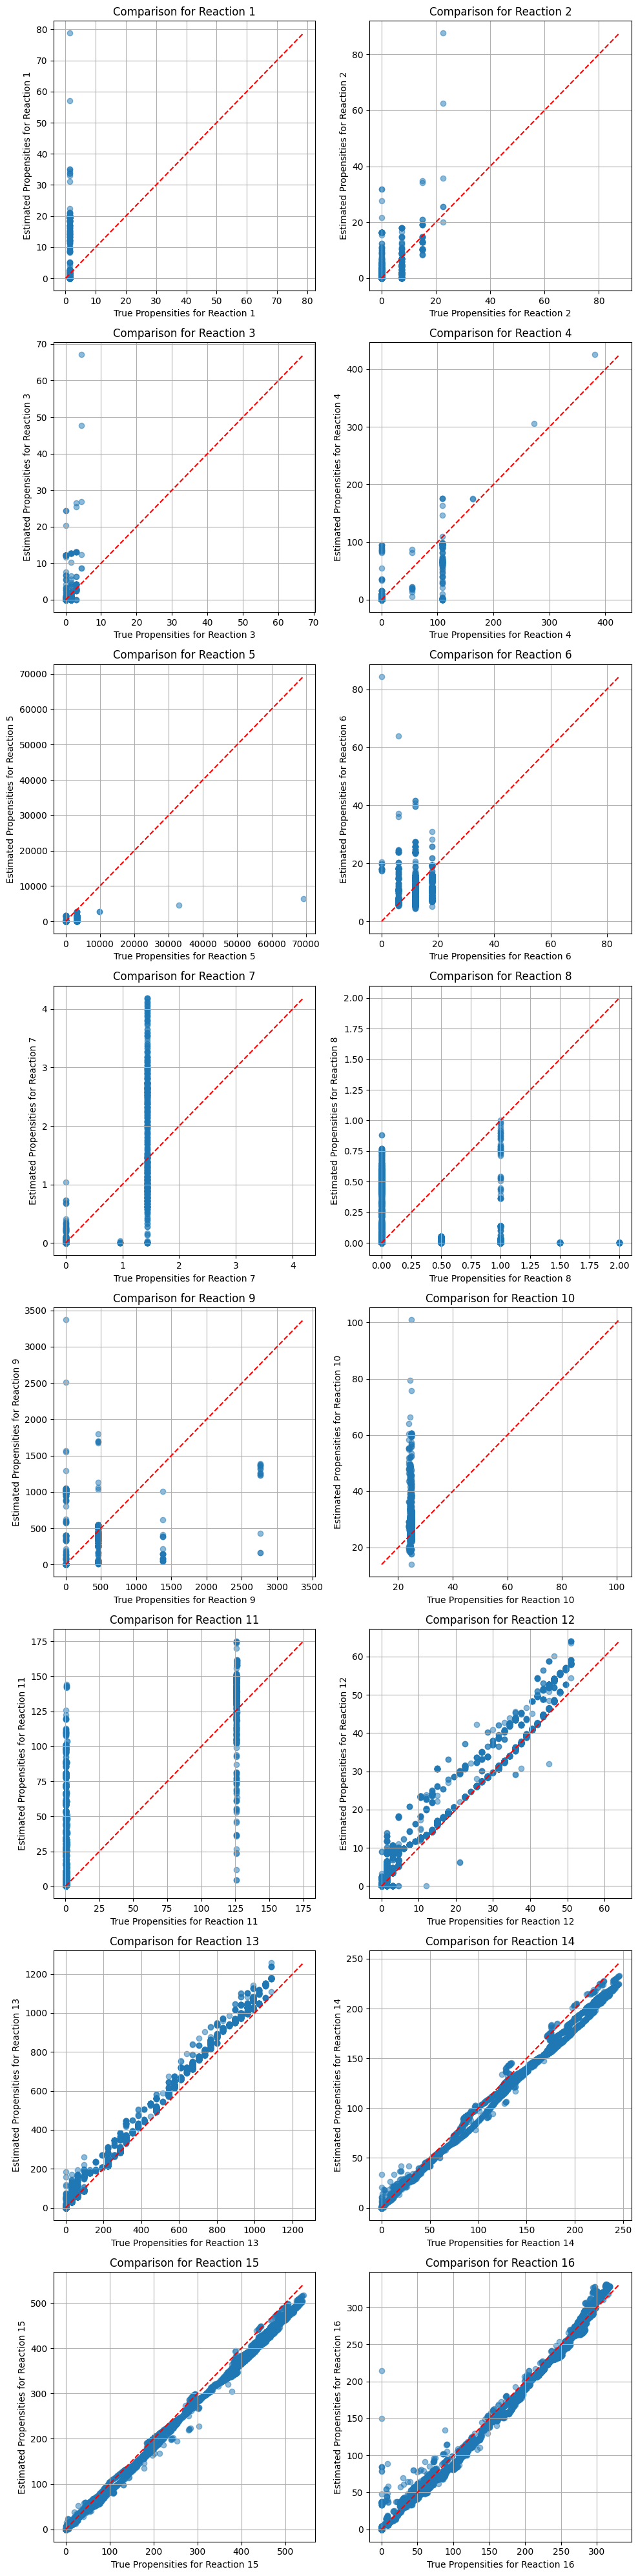

In [12]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lac.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)